0.8465412529430982 0.8465412529430982
First scale 19.10265372443525 : Second scale 12.399216694203886
0.8851702480028807 0.8851702480028806
First scale 20.417406222957023 : Second scale 13.258928319028712
0.8808693216243869 0.8808693216243869
First scale 20.259921714265808 : Second scale 13.193530199853287
0.9981800752051588 0.9981800752051588
First scale 18.295279015017776 : Second scale 8.506163757151425
0.9373189279674178 0.9373189279674179
First scale 29.074636499424233 : Second scale 17.27980278177991
0.9760369273998216 0.9760369273998216
First scale 25.670767454352553 : Second scale 15.841554939852774
0.9985878466006055 0.9985878466006055
First scale 21.201168545378845 : Second scale 12.358993681819735
0.9999379416389211 0.9999379416389212
First scale 20.83971443872725 : Second scale 14.920668509018086
0.999284353136826 0.999284353136826
First scale 16.70655226021138 : Second scale 6.877243151410487
0.9151362791295208 0.9151362791295206
First scale 18.33698300231943 : Second scal

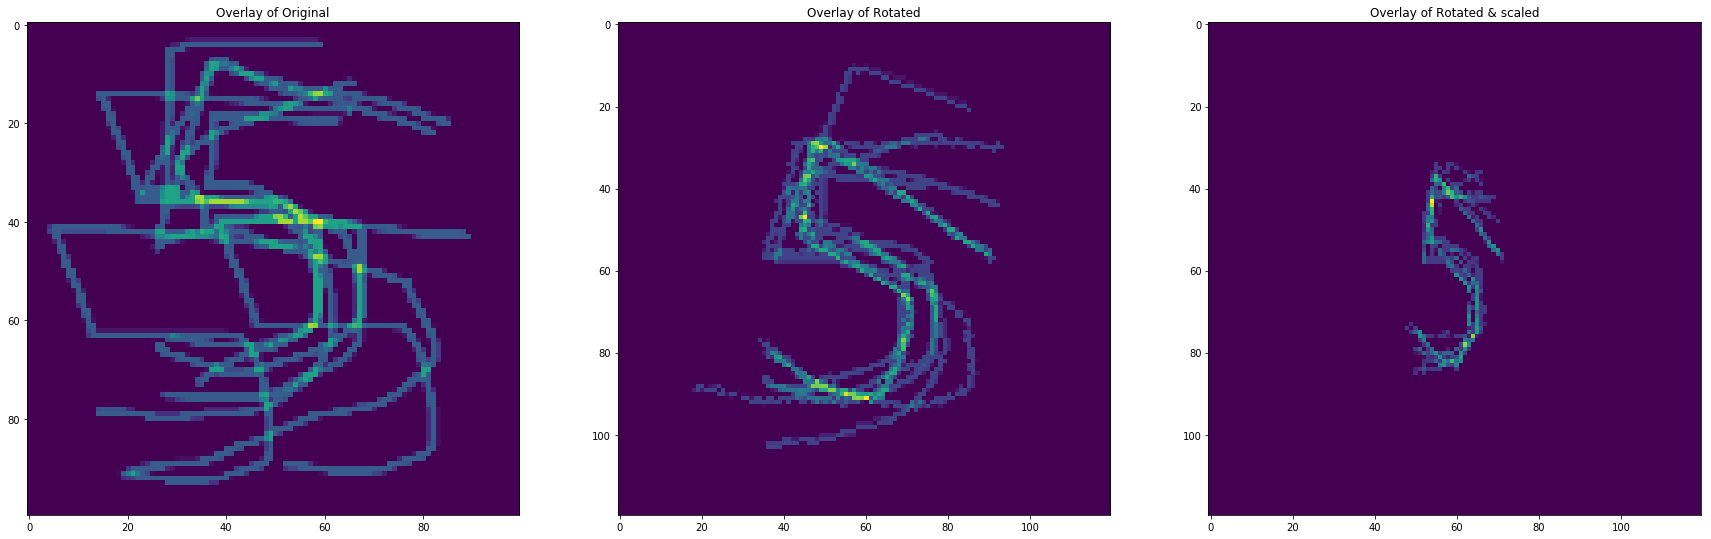

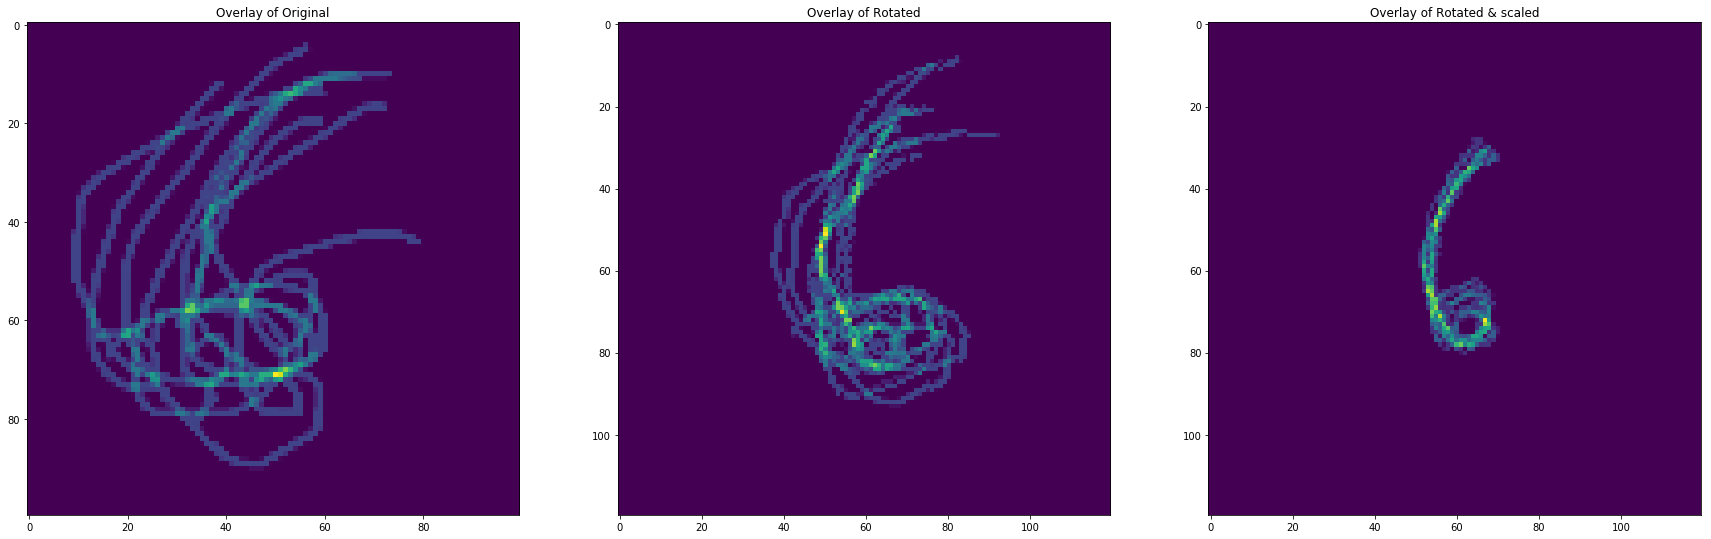

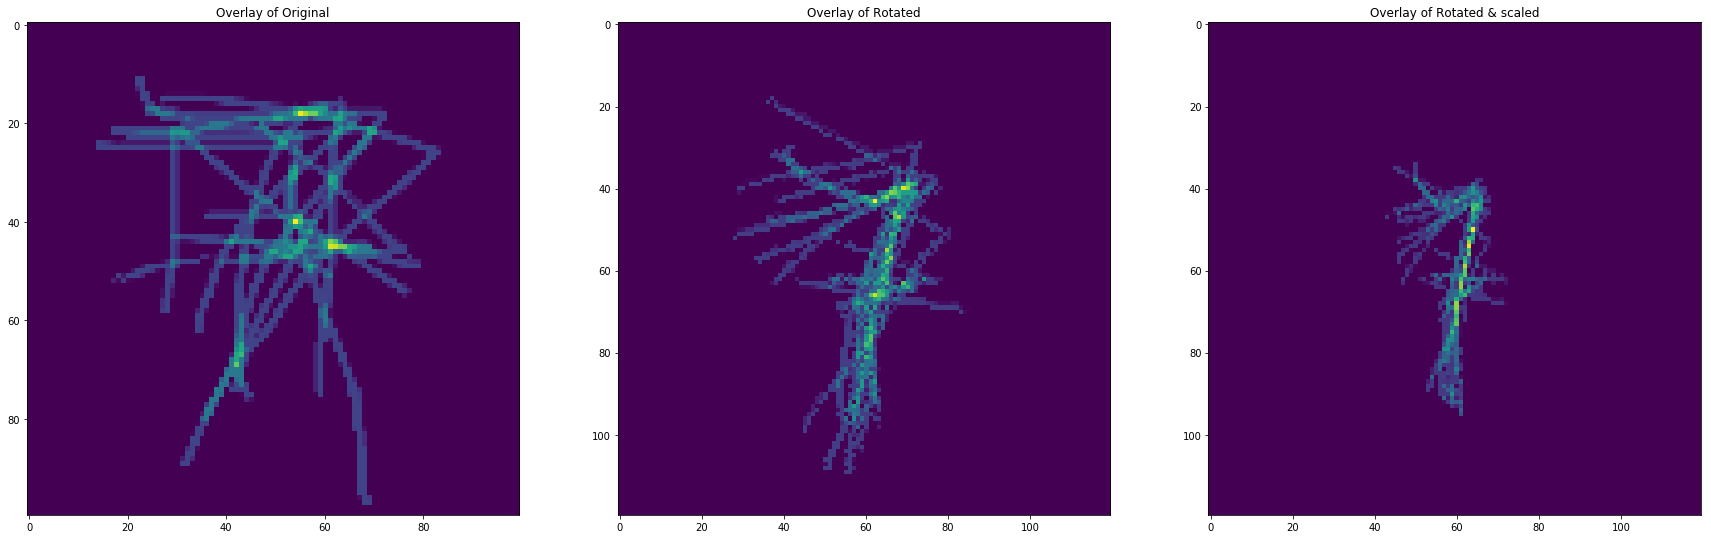

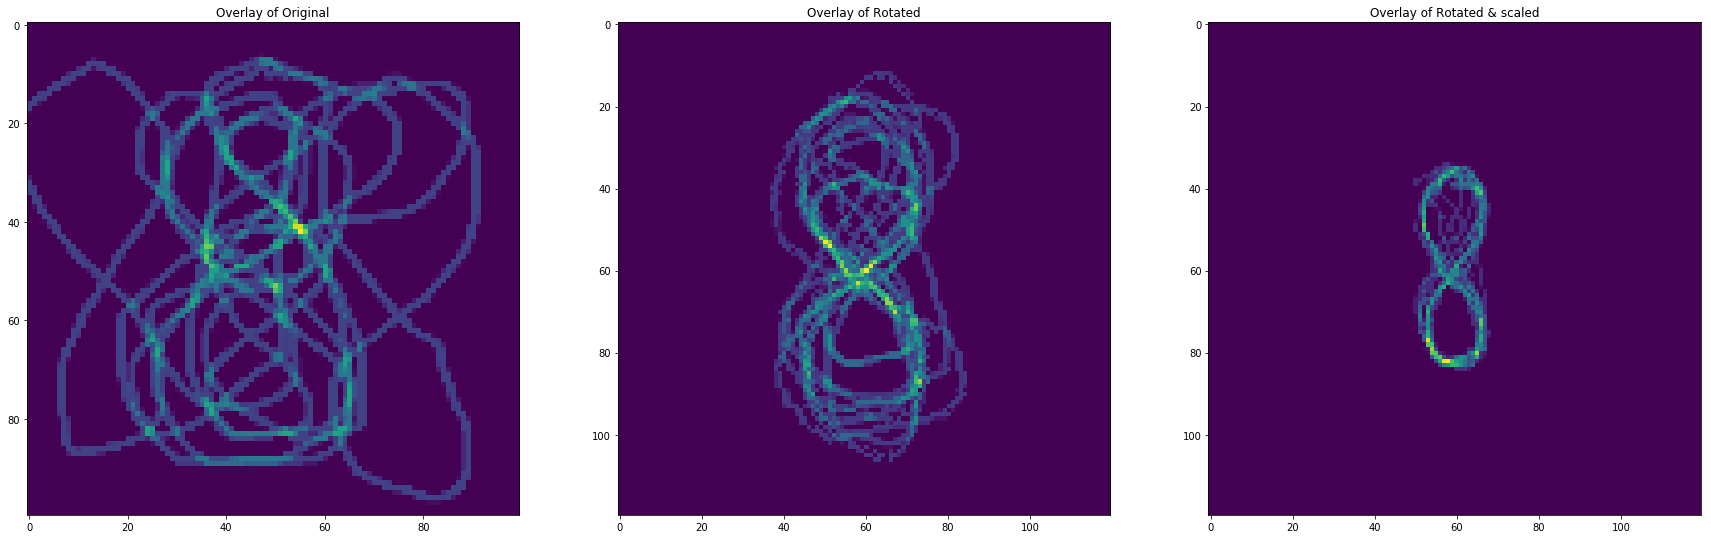

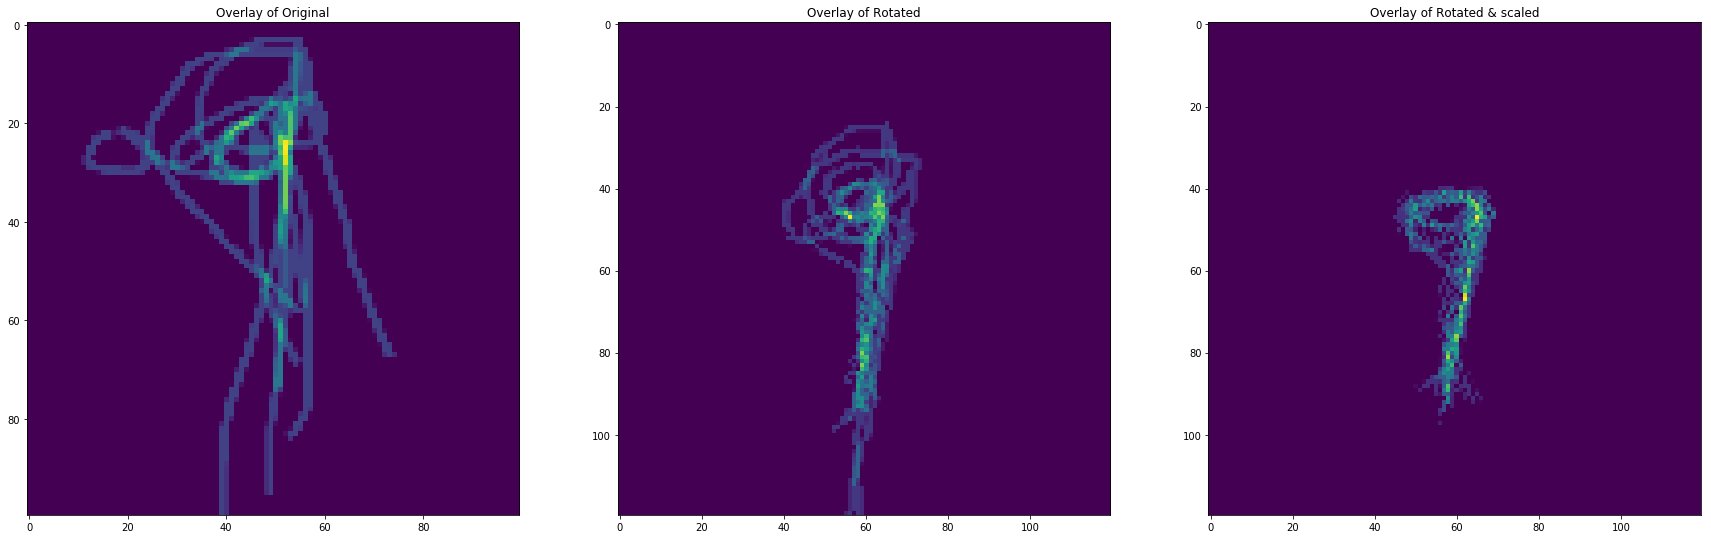

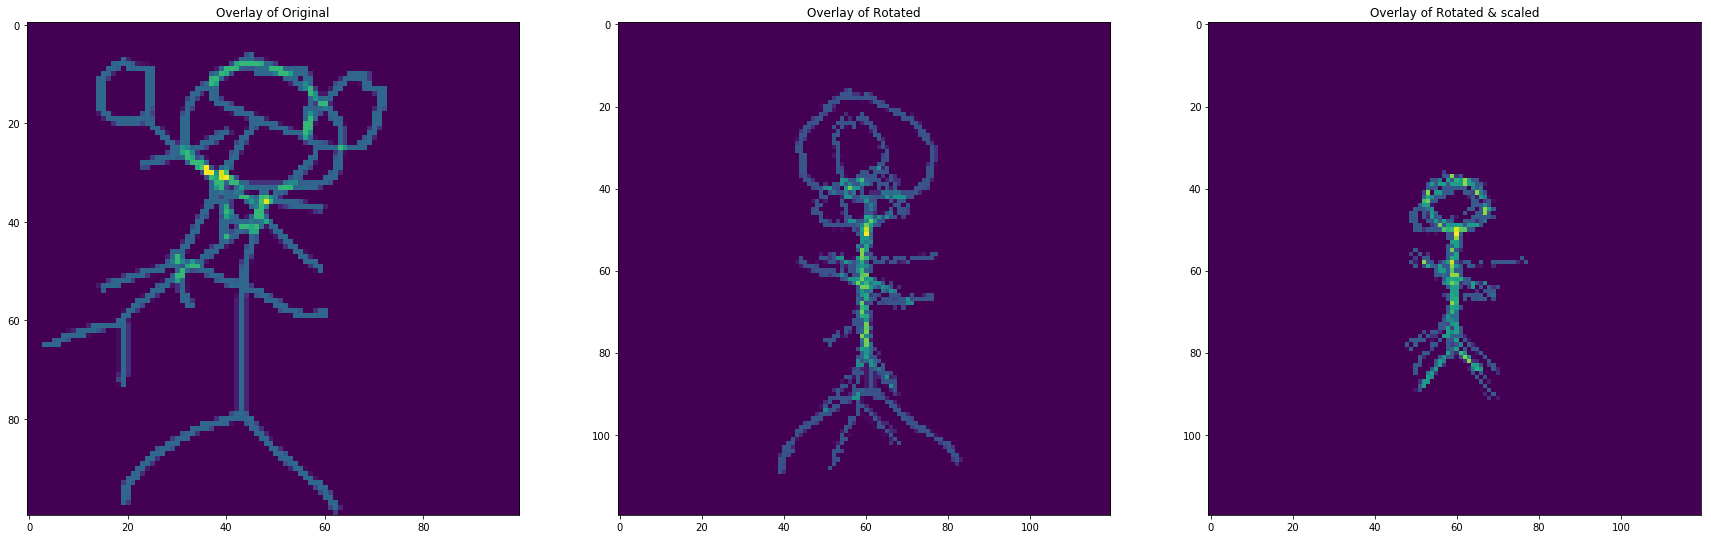

In [314]:
from wpca import WPCA
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from natsort import natsorted
from pandas import DataFrame
import pandas as pd
import matplotlib.cm as cm
cmap = cm.hot

def get_img_files(folder):
    files = list(filter(lambda file: any(ext in file.lower() for ext in ['png','jpg','bmp']), os.listdir(folder)))
    files = natsorted(files)[::1]
    images = list(map(lambda x: cv2.imread(folder+'/'+x, 0), files))
    return np.array(images)

def img_to_coord(img):
    coord_mat = np.ones((3, img.shape[0]*img.shape[1]))
    count = 0
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            coord_mat[:, count] = np.array([x, img.shape[0]-y, img[y,x]])
            count += 1
    return coord_mat

def plot_coord_mat(coord_mat, ax):
    ax.scatter(coord_mat[0, :], coord_mat[1, :], c=coord_mat[2, :])

def rotation_matrix(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
    return R

def weighted_pca_regression(x_vec, y_vec, weights):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    input_mat = np.stack([x_vec, y_vec])
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
    centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
    matrix_centered = np.stack([centered_x, centered_y])
    weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
    # We know that v rotates the data's main component onto the y=0 axis, and
    # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
    # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
    u,e,v = np.linalg.svd(weighted_cov)
    eig_val = np.sqrt(e)
    print(u[1,0], u[0,1])
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
        
    return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
        
def coord_to_img(coord_mat, bbox=[-60,60,-60,60]):
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    width = x_max - x_min
    height = y_max - y_min
    
    img = np.zeros([y_max-y_min, x_max-x_min])
    for col in range(coord_mat.shape[1]):
        x = coord_mat[0, col]
        y = coord_mat[1, col]
        val = coord_mat[2, col]
        new_x = int(x - x_min)
        new_y = int(y_max - y)
        if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
            img[new_y, new_x] = val
    return img
    
for folder in ['fives','sixes','sevens','eights','nines','people']:
    imgs = get_img_files(os.getcwd()+'/'+folder)

    coord_mats = []
    transformed_mats = []
    transformed_mats_2 = []
    # fig, ax = plt.subplots(3, figsize=(10,10))
    for index, img in enumerate(imgs[:]):
        img = cv2.resize(img, (100,100))
        img = img/img.max()
    #     fig, ax = plt.subplots(1, 2, figsize=(9,9))
    #     ax.imshow(img)

        coord_mat = img_to_coord(img)

        weights = coord_mat[2, :]

        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
#         print(angle, 90-angle)
    #     ax[0].arrow(*mean_vector, *(primary_vector), width=1, head_width=4, head_length=4)
    #     ax[0].arrow(*mean_vector, *(seconday_vector), width=1, head_width=4, head_length=4)
        R = rotation_matrix(90-angle)
        scale_mat = np.zeros([3,3])
        scale_mat[:2,0] = 0.5
        scale_mat[:2,1] = 2
        scale_mat[2,2] = 1
    #     second_scale_mat = np.matmul(scale_mat, np.diag([1, 1, 1]))
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        plot_coord_mat(coord_mat, ax[0])
    #     transformed_mat = np.matmul(R, np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat)) )
    #     transformed_mat = np.matmul(np.diag([0.01,0.01,1]), np.matmul(R, coord_mat - mean_mat))
    #     transformed_mat = np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat))
    #     transformed_mat = np.matmul(second_scale_mat,coord_mat - mean_mat)
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        print("First scale", eig_1, ": Second scale", eig_2)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 5/eig_2
        norm_scale_mat[1,1] = 15/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
    #     transformed_mat = coord_mat - mean_mat
        plot_coord_mat(transformed_mat, ax[1])
        ax[0].set_xlim([0,100])
        ax[0].set_ylim([0,100])
        ax[1].set_xlim([-60,60])
        ax[1].set_ylim([-60,60])
        ax[1].set_title("{}, {}".format(eig_1, eig_2))

        coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
        transformed_mats_2.append(coord_to_img(np.matmul(R, coord_mat - mean_mat).copy(), bbox=[-60,60,-60,60]))
        transformed_mats.append(coord_to_img(transformed_mat.copy(), bbox=[-60,60,-60,60]))

    fig2, ax2 = plt.subplots(1,3,figsize=(30,30))
    combined_orig = []
    combined_transformed = []
    # plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
    combined_orig = sum(coord_mats)
    combined_transformed = sum(transformed_mats)
    combined_transformed_2 = sum(transformed_mats_2)
    ax2[0].imshow(combined_orig)
    ax2[0].set_title("Overlay of Original")
    ax2[1].imshow(combined_transformed_2)
    ax2[1].set_title("Overlay of Rotated")
    ax2[2].imshow(combined_transformed)
    ax2[2].set_title("Overlay of Rotated & scaled")
    fig2.savefig("Sevens_full.png")
    # transformed_mats[1][2,:] += transformed_mats[0][2,:]
    # plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
    # # plot_coord_mat(transformed_mats[0], ax2[1])
    # plot_coord_mat(transformed_mats[1], ax2[1])

0.8898005781278597 0.8898005781278598
62.84819831319607 27.15180168680393
0.28171107852775695 0.28171107852775695
163.63764620196253 -73.63764620196253
0.9536765762509826 0.9536765762509826
72.49230877498539 17.50769122501461
0.9920633031343021 0.9920633031343024
97.22345853821156 -7.22345853821156
-0.8539100161242008 -0.8539100161242008
58.63952587687935 31.360474123120653
0.8839000849923475 0.8839000849923475
117.88353216682678 -27.883532166826782
0.850796939814235 0.850796939814235
121.70154497605306 -31.701544976053057
0.9660758862077367 0.9660758862077367
75.03325536810064 14.96674463189936


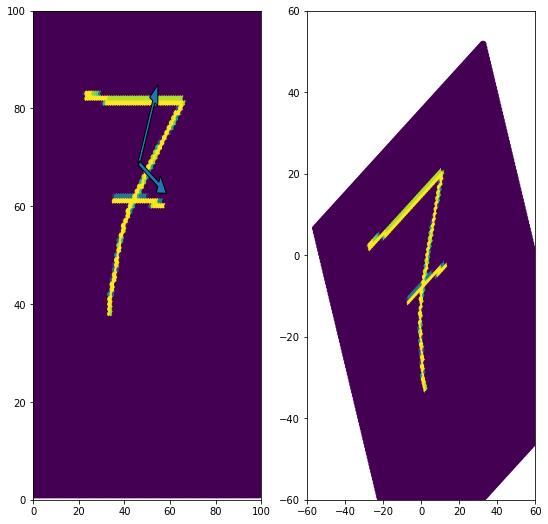

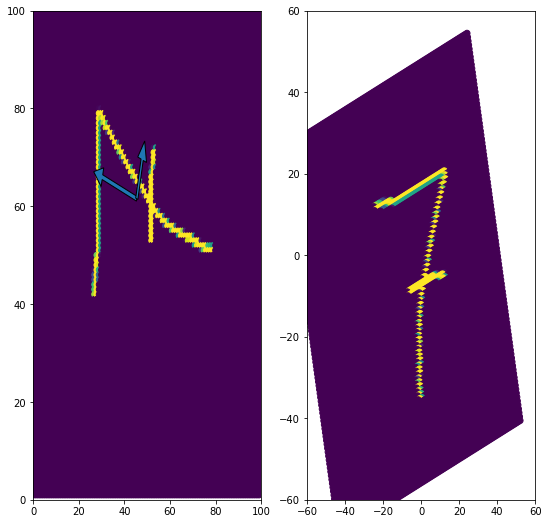

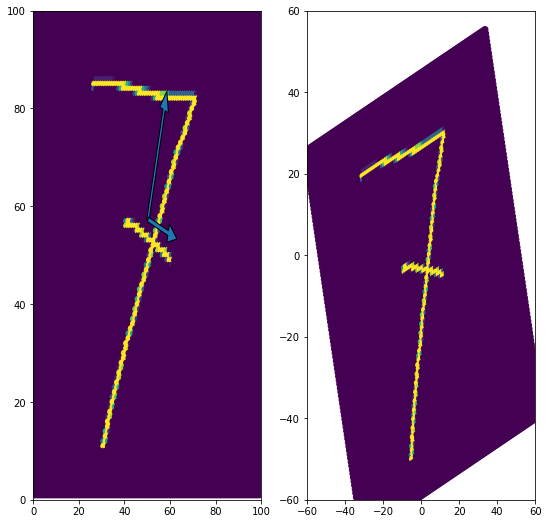

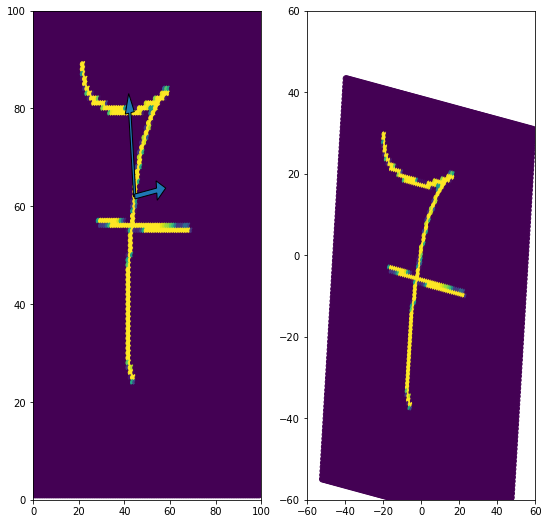

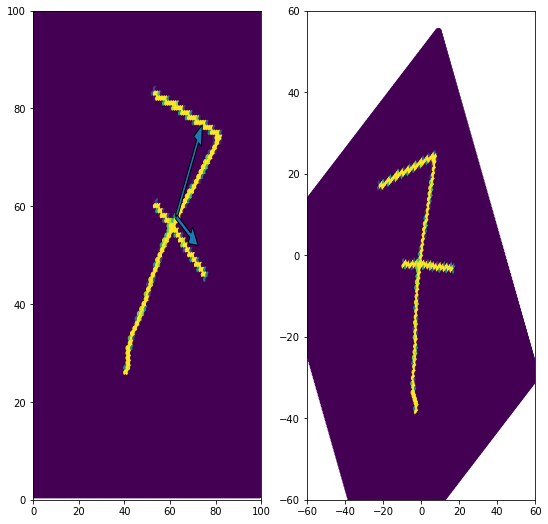

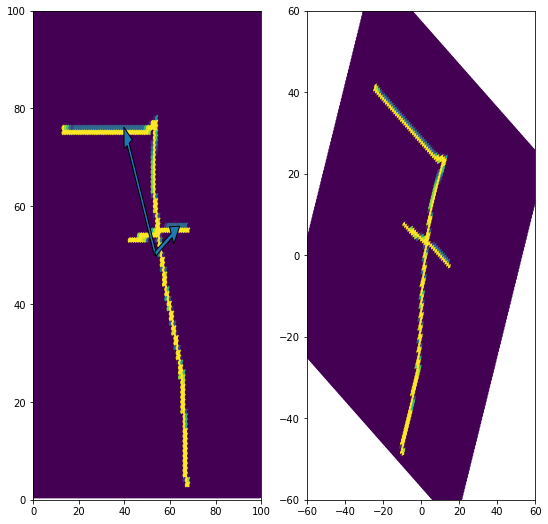

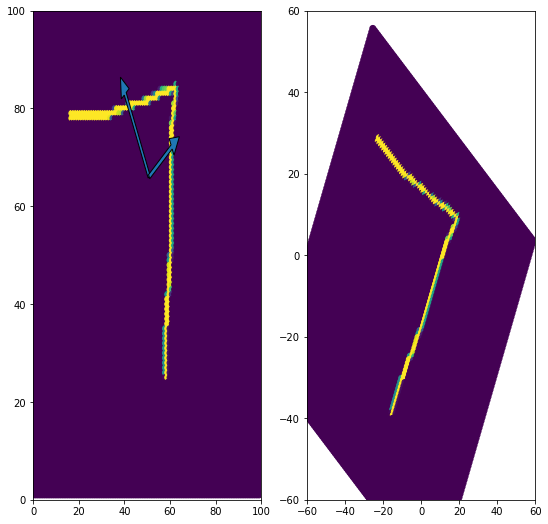

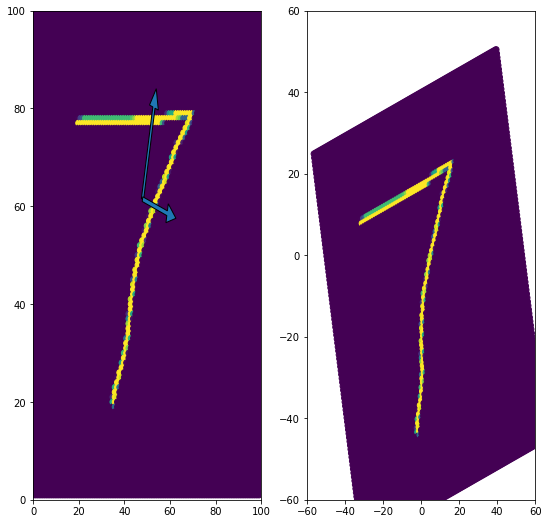

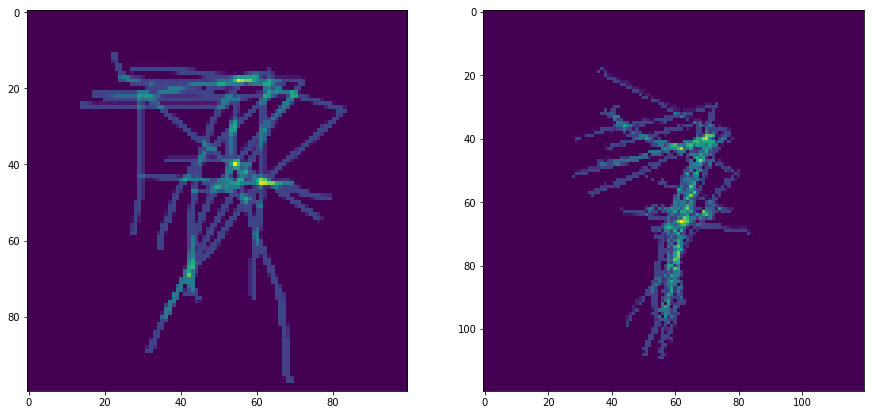

In [27]:
from wpca import WPCA
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from natsort import natsorted
from pandas import DataFrame
import pandas as pd
import matplotlib.cm as cm
cmap = cm.hot

def get_img_files(folder):
    files = list(filter(lambda file: any(ext in file.lower() for ext in ['png','jpg','bmp']), os.listdir(folder)))
    files = natsorted(files)[::1]
    images = list(map(lambda x: cv2.imread(folder+'/'+x, 0), files))
    return np.array(images)

def img_to_coord(img):
    coord_mat = np.ones((3, img.shape[0]*img.shape[1]))
    count = 0
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            coord_mat[:, count] = np.array([x, img.shape[0]-y, img[y,x]])
            count += 1
    return coord_mat

def plot_coord_mat(coord_mat, ax):
    ax.scatter(coord_mat[0, :], coord_mat[1, :], c=coord_mat[2, :])

def rotation_matrix(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
    return R

def weighted_pca_regression(x_vec, y_vec, weights):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    input_mat = np.stack([x_vec, y_vec])
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
    centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
    matrix_centered = np.stack([centered_x, centered_y])
    weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
    # We know that v rotates the data's main component onto the y=0 axis, and
    # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
    # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
    u,e,v = np.linalg.svd(weighted_cov)
    eig_val = np.sqrt(e)
    print(u[1,0], u[0,1])
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
        
    return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
        
def coord_to_img(coord_mat, bbox=[-60,60,-60,60]):
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    width = x_max - x_min
    height = y_max - y_min
    
    img = np.zeros([y_max-y_min, x_max-x_min])
    for col in range(coord_mat.shape[1]):
        x = coord_mat[0, col]
        y = coord_mat[1, col]
        val = coord_mat[2, col]
        new_x = int(x - x_min)
        new_y = int(y_max - y)
        if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
            img[new_y, new_x] = val
    return img
    
    
imgs = get_img_files(os.getcwd()+'/images')

coord_mats = []
transformed_mats = []
# fig, ax = plt.subplots(3, figsize=(10,10))
for index, img in enumerate(imgs[:8]):
    img = cv2.resize(img, (100,100))
    img = img/img.max()
    fig, ax = plt.subplots(1, 2, figsize=(9,9))
#     ax.imshow(img)
    
    coord_mat = img_to_coord(img)

    weights = coord_mat[2, :]

    primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
    angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
    print(angle, 90-angle)
    ax[0].arrow(*mean_vector, *(primary_vector), width=1, head_width=4, head_length=4)
    ax[0].arrow(*mean_vector, *(seconday_vector), width=1, head_width=4, head_length=4)
    R = rotation_matrix(90-angle)
    scale_mat = np.zeros([3,3])
    scale_mat[:2,0] = primary_vector/np.linalg.norm(primary_vector)
    scale_mat[:2,1] = seconday_vector/np.linalg.norm(seconday_vector)
    scale_mat[2,2] = 1
    second_scale_mat = np.matmul(scale_mat, np.diag([1, 1, 1]))
    mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
    mean_mat = np.diag(mean_mat)
    mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
    plot_coord_mat(coord_mat, ax[0])
    transformed_mat = np.matmul(R, np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat)) )
#     transformed_mat = np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat))
#     transformed_mat = np.matmul(second_scale_mat,coord_mat - mean_mat)
#     transformed_mat = np.matmul(R, coord_mat - mean_mat)
#     transformed_mat = coord_mat - mean_mat
    plot_coord_mat(transformed_mat, ax[1])
    ax[0].set_xlim([0,100])
    ax[0].set_ylim([0,100])
    ax[1].set_xlim([-60,60])
    ax[1].set_ylim([-60,60])
    
    coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
    transformed_mats.append(coord_to_img(transformed_mat.copy(), bbox=[-60,60,-60,60]))
    
fig, ax2 = plt.subplots(1,2,figsize=(15,15))
combined_orig = []
combined_transformed = []
# plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
combined_orig = sum(coord_mats)
combined_transformed = sum(transformed_mats)
ax2[0].imshow(combined_orig)
ax2[1].imshow(combined_transformed)

# transformed_mats[1][2,:] += transformed_mats[0][2,:]
# plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
# # plot_coord_mat(transformed_mats[0], ax2[1])
# plot_coord_mat(transformed_mats[1], ax2[1])

In [202]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter

def img_to_coord_tensor(img_tensor):
    height, width = img_tensor.shape
    img_tensor = torch.transpose(img_tensor, 0, 1).contiguous().view(1, width * height)

    x_coord = Variable(torch.arange(0, width)).view(width, 1)
    x_coord = x_coord.expand(width, height).contiguous()
    x_coord = x_coord.view(1, width * height)

    y_coord = Variable(torch.arange(height - 1,-1,-1))
    y_coord = y_coord.expand(width, height).contiguous()
    y_coord = y_coord.view(1,width * height)

    coord_mat = torch.cat((x_coord, y_coord))
    img_tensor = torch.cat((coord_mat, img_tensor))

    return img_tensor

img = Variable(torch.FloatTensor([[20,11,0],[0,1,0],[7,9,5]]), requires_grad=False)
img2 = Variable(torch.FloatTensor([[20,11], [0,1],[7,9], [1,5]]), requires_grad=False)
print(img)
h, w = img.shape
print(w,h)
coord_mat = img_to_coord_tensor(img)
rotate_mat = Variable(torch.ones(9,3))
print(rotate_mat.shape, coord_mat.shape)
print(rotate_mat)
rotate_mat = torch.mm(coord_mat, rotate_mat)
print(rotate_mat)
print(coord_mat)

class CoordTransform(torch.nn.Module):

    def __init__(self):
        super(CoordTransform, self).__init__()
        self.img_tensor = img_tensor
    
    def forward(self, img_tensor):
        height, width = img_tensor.shape
        img_tensor = torch.transpose(img_tensor, 0, 1).contiguous().view(1, width * height)

        x_coord = Variable(torch.arange(0, width)).view(width, 1)
        x_coord = x_coord.expand(width, height).contiguous()
        x_coord = x_coord.view(1, width * height)

        y_coord = Variable(torch.arange(height - 1,-1,-1))
        y_coord = y_coord.expand(width, height).contiguous()
        y_coord = y_coord.view(1, width * height)

        coord_mat = torch.cat((x_coord, y_coord))
        img_tensor = torch.cat((img_tensor, coord_mat))
        return img_tensor
    
class AffineUnitary(torch.nn.Module):
    def __init__(self, size_in, size_out):
        super(AffineUnitary, self).__init__()
    
    def forward(self, coord_mat):
        primary_vector, seconday_vector, mean_vector = self.weighted_pca_regression(coord_mat.data.numpy()[0,:],
                                                                               coord_mat.data.numpy()[1,:],
                                                                               coord_mat.data.numpy()[2,:])
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        
        R = rotation_matrix(90-angle)
        
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        mean_mat = torch.from_numpy(mean_mat)

        
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 5/eig_2
        norm_scale_mat[1,1] = 15/eig_1
        norm_scale_mat[2,2] = 1
        norm_scale_mat = torch.from_numpy(norm_scale_mat)
        
        coord_mat = torch.mm(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        
        coord_mat
        return coord_mat
    
    def weighted_pca_regression(self, x_vec, y_vec, weights):
        """
        Given three real-valued vectors of same length, corresponding to the coordinates
        and weight of a 2-dimensional dataset, this function outputs the angle in radians
        of the line that aligns with the (weighted) average and main linear component of
        the data. For that, first a weighted mean and covariance matrix are computed.
        Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
        """
        input_mat = np.stack([x_vec, y_vec])
        weights_sum = weights.sum()
        # Subtract (weighted) mean and compute (weighted) covariance matrix:
        mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
        centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
        matrix_centered = np.stack([centered_x, centered_y])
        weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
        # We know that v rotates the data's main component onto the y=0 axis, and
        # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
        # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
        u,e,v = np.linalg.svd(weighted_cov)
        eig_val = np.sqrt(e)
        print(u[1,0], u[0,1])
        if u[1,0] < 0:
            eig_val[0] = -1*eig_val[0]
        if u[0,1] < 0:
            eig_val[1] = -1*eig_val[1]

        return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
    
    def coord_to_img(self, coord_mat, bbox=[-60,60,-60,60]):
        x_min = bbox[0]
        x_max = bbox[1]
        y_min = bbox[2]
        y_max = bbox[3]
        width = x_max - x_min
        height = y_max - y_min

        img = torch.zeros([y_max-y_min, x_max-x_min])
        for col in range(coord_mat.shape[1]):
            x = coord_mat[0, col]
            y = coord_mat[1, col]
            val = coord_mat[2, col]
            new_x = int(x - x_min)
            new_y = int(y_max - y)
            if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
                img[new_y, new_x] = val
        return img
    
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.conv2D(1,10)
        self.conv1 = torch.nn.conv2D(1,10)
        
    def forward(self, x):
        pass

Variable containing:
 20  11   0
  0   1   0
  7   9   5
[torch.FloatTensor of size 3x3]

3 3
torch.Size([9, 3]) torch.Size([3, 9])
Variable containing:
    1     1     1
    1     1     1
    1     1     1
    1     1     1
    1     1     1
    1     1     1
    1     1     1
    1     1     1
    1     1     1
[torch.FloatTensor of size 9x3]

Variable containing:
  9   9   9
  9   9   9
 53  53  53
[torch.FloatTensor of size 3x3]

Variable containing:
    0     0     0     1     1     1     2     2     2
    2     1     0     2     1     0     2     1     0
   20     0     7    11     1     9     0     0     5
[torch.FloatTensor of size 3x9]



In [125]:
x_cord = torch.arange(0,3).view(3,1)
x_cord = x_cord.expand(3,4).contiguous()
x_cord = x_cord.view(1,12)
print(x_cord, x_cord.shape)


    0     0     0     0     1     1     1     1     2     2     2     2
[torch.FloatTensor of size 1x12]
 torch.Size([1, 12])


In [200]:
y_cord = Variable(torch.arange(3,-1,-1))
y_cord = y_cord.expand(3,4).contiguous()
y_cord = y_cord.view(3,4)
print(y_cord)
print(y_cord[:,1])

Variable containing:
 3  2  1  0
 3  2  1  0
 3  2  1  0
[torch.FloatTensor of size 3x4]

Variable containing:
 2
 2
 2
[torch.FloatTensor of size 3]



Variable containing:
 20  11   9
  8   5   4
  3   2   1
[torch.FloatTensor of size 3x3]

Variable containing:
   20    11     9     8     5     4     3     2     1
[torch.FloatTensor of size 1x9]

Variable containing:
 0  1  2
[torch.FloatTensor of size 1x3]

Variable containing:
    0     1     2     0     1     2     0     1     2
[torch.FloatTensor of size 1x9]

[[-1. -1.  0. -1.  0.  1.  0.  1.  1.]
 [ 1.  2.  3.  1.  1.  2.  0.  1.  1.]
 [20. 11.  9.  8.  5.  4.  3.  2.  1.]]
[[ 0.   -0.71  0.71 -1.41  0.    1.41 -0.71  0.71  0.  ]
 [ 2.83  2.12  2.12  1.41  1.41  1.41  0.71  0.71  0.  ]
 [ 9.   11.    4.   20.    5.    1.    8.    2.    3.  ]]


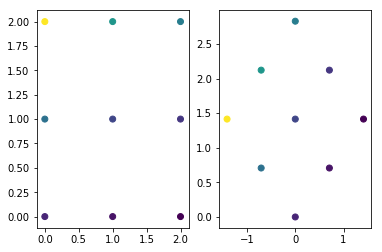

In [306]:
img_tensor = Variable(torch.FloatTensor([[20,11,9],[8,5,4],[3,2,1]]), requires_grad=False)
print(img_tensor)

print(img_tensor.view(1,9))
height, width = img_tensor.shape
img_tensor = img_tensor.view(1, width * height)

x_coord = Variable(torch.arange(0, width)).view(1, width)
print(x_coord)
x_coord = x_coord.expand(height, width).contiguous()
x_coord = x_coord.view(1, width * height)
print(x_coord)

y_coord = Variable(torch.arange(height - 1,-1,-1).view(height,1))
y_coord = y_coord.expand(width, height).contiguous()
y_coord = y_coord.view(1,width * height)

fig, ax = plt.subplots(1,2)
coord_mat = torch.cat((x_coord, y_coord))
img_tensor = torch.cat((coord_mat, img_tensor))
R = rotation_matrix(45)
img_tensor = img_tensor.data.numpy()
plot_coord_mat(img_tensor, ax[0])
# print(np.round_(img_tensor))

img_tensor = np.matmul(R, img_tensor)
print(np.round_(img_tensor))
# print(np.round_(img_tensor))
b = (8,2,2)
a = (3,1,2)
ind = np.lexsort((img_tensor[0,:],-1*img_tensor[1,:]))
print(np.round_(img_tensor[:,ind], decimals=2))
plot_coord_mat(img_tensor, ax[1])

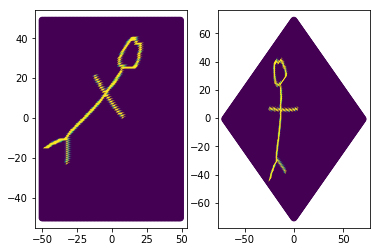

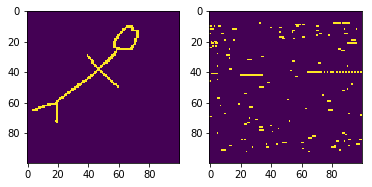

In [440]:
img_tensor = Variable(torch.Tensor(coord_mats[0]), requires_grad=False)
img_tensor.shape

height, width = img_tensor.shape
img_tensor = img_tensor.view(1, width * height)

x_coord = Variable(torch.arange(0, width)).view(1, width)

x_coord = x_coord.expand(height, width).contiguous()
x_coord = x_coord.view(1, width * height)
x_coord = x_coord - 50

y_coord = Variable(torch.arange(height - 1,-1,-1).view(height,1))
y_coord = y_coord.expand(width, height).contiguous()
y_coord = y_coord.view(1,width * height)
y_coord = y_coord - 50

fig, ax = plt.subplots(1,2)
coord_mat = torch.cat((x_coord, y_coord))
img_tensor = torch.cat((coord_mat, img_tensor))
R = rotation_matrix(45)
img_tensor = img_tensor.data.numpy()
plot_coord_mat(img_tensor, ax[0])
# print(np.round_(img_tensor))
print()
img_tensor23 = np.matmul(R, img_tensor)
plot_coord_mat(img_tensor23, ax[1])

def coord_mat_to_img(coord_mat, width, height):
    coord_mat = np.round_(coord_mat)
    ind = np.lexsort((coord_mat[0,:],-1*coord_mat[1,:]))
    coord_mat = coord_mat[:,ind]
    pixels = coord_mat[2,:width*height]
    pixels = np.reshape(pixels, (height, width))
    return pixels

fig2, ax2 = plt.subplots(1,2)
ax2[0].imshow(coord_mat_to_img(img_tensor, 100, 100))
ax2[1].imshow(coord_mat_to_img(img_tensor23, 100, 100))

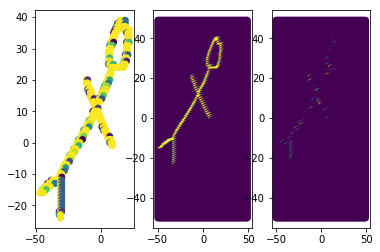

In [464]:
def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

fig, ax = plt.subplots(1,3)
copy_tensor = img_tensor.copy()
img_tensor2 = img_tensor.copy()
# np.round_(img_tensor2[img_tensor2[1:] > 25])
plot_coord_mat(copy_tensor, ax[1])

 

# bigger = np.logical_and(bigger[0,:],bigger[1,:])

# less = np.less(img_tensor2, max_box)
# # less = np.logical_and(less[0,:],less[1,:])
# img_tensor2 = img_tensor2[:,less[2,:]]
plot_coord_mat(object_extraction(img_tensor2), ax[0])
plot_coord_mat(img_tensor2, ax[2])
# ax[2].imshow(coord_mat_to_img(img_tensor2, 64, 62))

    
    
    

In [386]:
data = np.array([[4,2,1],[3,5,2],[7,1,8]])
x_min = np.repeat([[0],[1],[2]], data.shape[0], axis=1)
print(x_min)
print(data)
print(np.greater(data,x_min))
bigger = np.greater(data,x_min)
bigger = np.logical_and(bigger[0,:],bigger[1,:])
print(bigger)
data[:,bigger]


[[0 0 0]
 [1 1 1]
 [2 2 2]]
[[4 2 1]
 [3 5 2]
 [7 1 8]]
[[ True  True  True]
 [ True  True  True]
 [ True False  True]]
[ True  True  True]


array([[4, 2, 1],
       [3, 5, 2],
       [7, 1, 8]])